# Setup Enviroment

In [ ]:
import os
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

# Dependencies and Dataset

## Install Dependencies

In [3]:
!pip install -q numpy==1.26.4
!pip install -q tensorflow==2.18.0
!pip install opencv-python==4.11.0.86
!pip install -q scikit-image==0.25.2
!pip install -q matplotlib==3.7.2

## Download Dataset

In [ ]:
import os
ds_path = "dataset/landscape-pictures"
os.makedirs(ds_path, exist_ok=True)

In [5]:
!curl -L https://www.kaggle.com/api/v1/datasets/download/arnaud58/landscape-pictures -o ./dataset/landscape-pictures.zip

import zipfile
with zipfile.ZipFile('dataset/landscape-pictures.zip', 'r') as zip_ref:
    zip_ref.extractall(ds_path)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  620M  100  620M    0     0   100M      0  0:00:06  0:00:06 --:--:--  120M


# Import Libraries

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.layers import (
    Input, Dense, LayerNormalization, Dropout,
    MultiHeadAttention, Add, Conv2D, Reshape, UpSampling2D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.mixed_precision import set_global_policy
import cv2
from skimage.color import rgb2lab, lab2rgb
from skimage.metrics import peak_signal_noise_ratio
import matplotlib.pyplot as plt
import glob
import os

2025-06-22 02:47:40.890208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750560461.160426      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750560461.211896      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Dataset Preparation


In [7]:
# Enable mixed precision training to reduce memory usage
set_global_policy('mixed_float16')

# Define constants
HEIGHT, WIDTH = 1024, 1024
BATCH_SIZE = 1
# Create directories for color and grayscale images
color_path = os.path.join(ds_path, 'color')
gray_path = os.path.join(ds_path, 'gray')
os.makedirs(color_path, exist_ok=True)
os.makedirs(gray_path, exist_ok=True)

# Organize and generate grayscale images
original_files = sorted(glob.glob(os.path.join(ds_path, '*.jpg')))
for f in original_files:
    color_file = os.path.join(color_path, os.path.basename(f))
    gray_file = os.path.join(gray_path, os.path.basename(f))
    if not os.path.exists(color_file):
        os.rename(f, color_file)
    if not os.path.exists(gray_file):
        img = cv2.imread(color_file)
        if img is not None:
            gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            cv2.imwrite(gray_file, gray_img)

# Load file paths
color_files = sorted(glob.glob(os.path.join(color_path, '*.jpg')))
gray_files = sorted([os.path.join(gray_path, os.path.basename(f)) for f in color_files])
assert len(color_files) == len(gray_files), "File count mismatch"

# Image generator for L*a*b* color space
def image_generator(file_pairs):
    for gray_file, color_file in file_pairs:
        gray_img = cv2.imread(gray_file, cv2.IMREAD_GRAYSCALE)
        color_img = cv2.imread(color_file, cv2.IMREAD_COLOR)
        if gray_img is None or color_img is None:
            continue
        gray_img = cv2.resize(gray_img, (WIDTH, HEIGHT))
        color_img = cv2.resize(color_img, (WIDTH, HEIGHT))
        color_img = color_img[:, :, ::-1]  # BGR to RGB
        lab_img = rgb2lab(color_img / 255.0)
        L = lab_img[:, :, 0:1] / 100.0  # Normalize L*
        ab = lab_img[:, :, 1:] / 128.0  # Normalize a*b*
        yield L, ab

# Split dataset
file_pairs = list(zip(gray_files, color_files))
np.random.seed(42)
np.random.shuffle(file_pairs)
train_size = int(0.8 * len(file_pairs))
train_pairs, val_pairs = file_pairs[:train_size], file_pairs[train_size:]

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_generator(
    lambda: image_generator(train_pairs),
    output_signature=(
        tf.TensorSpec(shape=(HEIGHT, WIDTH, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(HEIGHT, WIDTH, 2), dtype=tf.float32)
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: image_generator(val_pairs),
    output_signature=(
        tf.TensorSpec(shape=(HEIGHT, WIDTH, 1), dtype=tf.float32),
        tf.TensorSpec(shape=(HEIGHT, WIDTH, 2), dtype=tf.float32)
    )
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1750560515.625595      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


## Visualize some Samples

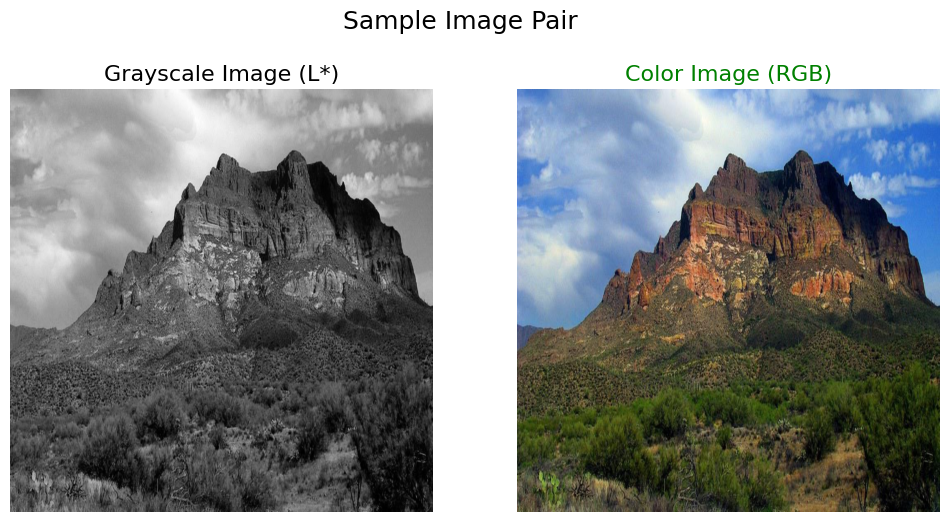

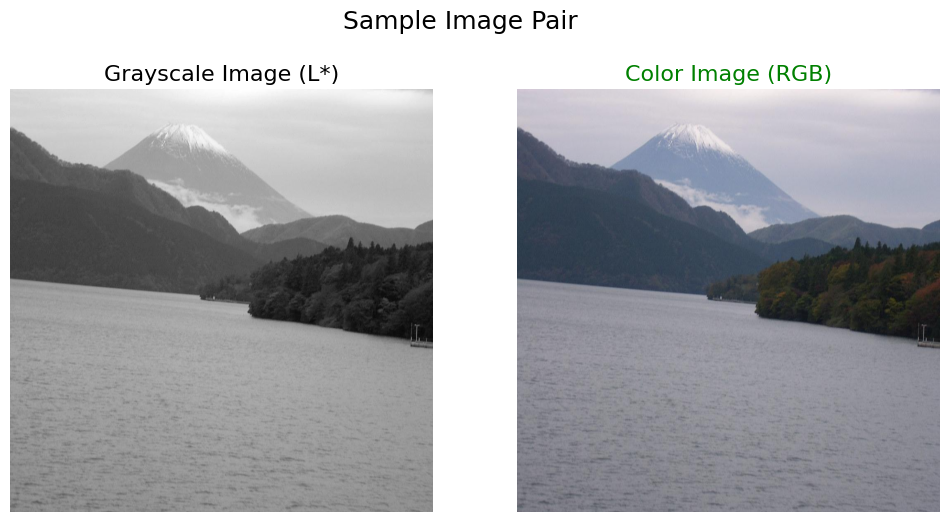

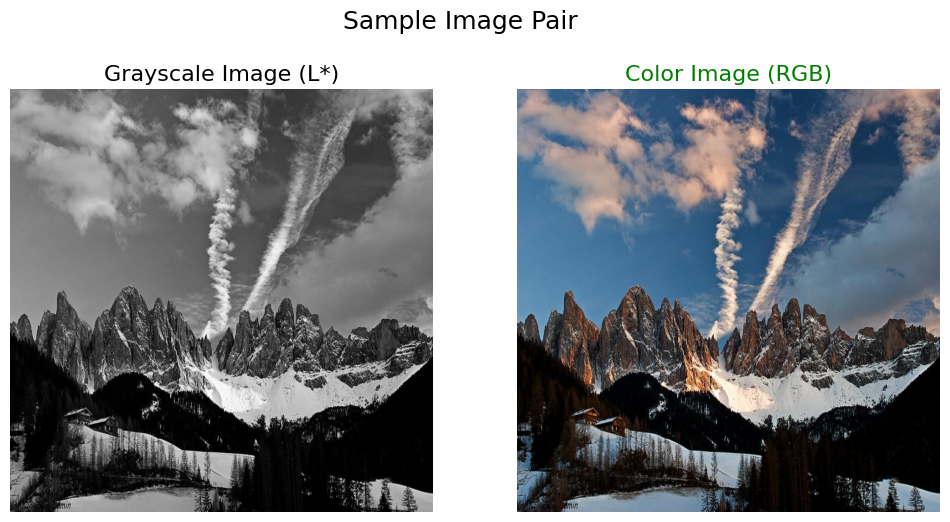

In [8]:
# Visualize sample image pairs
def plot_image_pair(L_img, ab_img, title='Image Pair'):
    L = L_img * 100.0
    ab = ab_img * 128.0
    lab = np.concatenate([L, ab], axis=-1)
    rgb = lab2rgb(lab)
    rgb = np.clip(rgb, 0, 1)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title('Grayscale Image (L*)', fontsize=16, color='black')
    plt.imshow(L[..., 0], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title('Color Image (RGB)', fontsize=16, color='green')
    plt.imshow(rgb)
    plt.axis('off')
    plt.suptitle(title, fontsize=18)
    plt.show()

for L_img, ab_img in train_dataset.take(3):
    plot_image_pair(L_img[0].numpy(), ab_img[0].numpy(), 'Sample Image Pair')

# Modeling

## Model Architecture

In [9]:
# Define Transformer model
@tf.keras.utils.register_keras_serializable()
def transformer_model(input_shape=(1024, 1024, 1), patch_size=8,
                      d_model=32, num_heads=4, ff_dim=64,
                      num_layers=2, dropout_rate=0.1):
    HEIGHT, WIDTH, _ = input_shape
    num_patches = (HEIGHT // patch_size) * (WIDTH // patch_size)
    
    inputs = Input(shape=input_shape)
    
    # Patch extraction
    x = Conv2D(d_model, (patch_size, patch_size), strides=(patch_size, patch_size), padding='valid')(inputs)
    x = Reshape((num_patches, d_model))(x)
    
    # Transformer layers
    for _ in range(num_layers):
        attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=d_model // num_heads)(x, x)
        attn_output = Dropout(dropout_rate)(attn_output)
        x = Add()([x, attn_output])
        x = LayerNormalization(epsilon=1e-6)(x)
        
        ff_output = Dense(ff_dim, activation='relu')(x)
        ff_output = Dense(d_model)(ff_output)
        ff_output = Dropout(dropout_rate)(ff_output)
        x = Add()([x, ff_output])
        x = LayerNormalization(epsilon=1e-6)(x)
    
    # Decoder: Reconstruct image
    x = Dense(2)(x)
    x = Reshape((HEIGHT // patch_size, WIDTH // patch_size, 2))(x)
    x = UpSampling2D(size=(patch_size, patch_size), interpolation='bilinear')(x)
    outputs = Conv2D(2, (3, 3), activation='tanh', padding='same')(x)
    
    return Model(inputs, outputs)

In [10]:
# Instantiate and compile the model
model = transformer_model(input_shape=(HEIGHT, WIDTH, 1),
                          patch_size=8, d_model=32, num_heads=4,
                          ff_dim=64, num_layers=2)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1024, 1024, 1)  │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 1024, 1024, 1)  │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 32)   │          2,080 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 16384, 32)      │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, 16384, 32)      │          4,224 │ reshape[0][0],         │
│ (MultiHeadAttention)      │                        │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 16384, 32)      │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 16384, 32)      │              0 │ reshape[0][0],         │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, 16384, 32)      │             64 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16384, 64)      │          2,112 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 16384, 32)      │          2,080 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 16384, 32)      │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 16384, 32)      │              0 │ layer_normalization[0… │
│                           │                        │                │ dropout_2[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization_1     │ (None, 16384, 32)      │             64 │ add_1[0][0]            │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention_1    │ (None, 16384, 32)      │          4,224 │ layer_normalization_1… │
│ (MultiHeadAttention)      │                        │                │ layer_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_4 (Dropout)       │ (None, 16384, 32)      │              0 │ multi_head_attention_… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_2 (Add)               │ (None, 16384, 32)      │              0 │ layer_normalization_1… │
│                           │                        │                │ dropout_4[0][0]        │
├──────────────────────

 Total params: 19,272 (75.28 KB)

 Trainable params: 19,272 (75.28 KB)

 Non-trainable params: 0 (0.00 B)

## CallBacks and Compile

In [11]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',       # Monitor validation loss
        patience=20,              # Stop after 10 epochs with no improvement
        restore_best_weights=True # Restore weights from the best epoch
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',       # Monitor validation loss
        factor=0.8,               # Reduce learning rate by 0.2
        patience=5,               # Wait 5 epochs before reducing
        min_lr=1e-6               # Minimum learning rate
    ),
    tf.keras.callbacks.BackupAndRestore(
        backup_dir='./ckpts/transformer/backup',     # Directory to save backup checkpoints
        delete_checkpoint=False
    )
]

# Model compile
model.compile(optimizer=Adam(learning_rate=7e-5), 
                   loss=tf.keras.losses.MeanSquaredError())

## Model Training

In [13]:
# Model Training
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)

Epoch 90/100


I0000 00:00:1750560524.410421     126 service.cc:148] XLA service 0x7fcfcc02cf50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750560524.411331     126 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1750560525.562605     126 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1750560527.186106     126 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750560527.375920     126 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
I0000 00:00:1750560534.745284     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   3455/Unknown 909s 259ms/step - loss: 0.0124

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


3455/3455 ━━━━━━━━━━━━━━━━━━━━ 1066s 304ms/step - loss: 0.0124 - val_loss: 0.0120 - learning_rate: 1.1744e-05
Epoch 91/100
3455/3455 ━━━━━━━━━━━━━━━━━━━━ 1046s 303ms/step - loss: 0.0124 - val_loss: 0.0120 - learning_rate: 1.1744e-05
Epoch 92/100
3455/3455 ━━━━━━━━━━━━━━━━━━━━ 1051s 304ms/step - loss: 0.0124 - val_loss: 0.0120 - learning_rate: 1.1744e-05
Epoch 93/100
3455/3455 ━━━━━━━━━━━━━━━━━━━━ 1046s 303ms/step - loss: 0.0124 - val_loss: 0.0120 - learning_rate: 1.1744e-05
Epoch 94/100
3455/3455 ━━━━━━━━━━━━━━━━━━━━ 1047s 303ms/step - loss: 0.0124 - val_loss: 0.0120 - learning_rate: 1.1744e-05
Epoch 95/100
3455/3455 ━━━━━━━━━━━━━━━━━━━━ 1048s 303ms/step - loss: 0.0124 - val_loss: 0.0120 - learning_rate: 1.1744e-05
Epoch 96/100
3455/3455 ━━━━━━━━━━━━━━━━━━━━ 1055s 305ms/step - loss: 0.0124 - val_loss: 0.0120 - learning_rate: 9.3952e-06
Epoch 97/100
3455/3455 ━━━━━━━━━━━━━━━━━━━━ 1050s 304ms/step - loss: 0.0123 - val_loss: 0.0120 - learning_rate: 9.3952e-06
Epoch 98/100
3455/3455 ━━━━━━

## Save the final model

In [ ]:
import os
# Create Model dir
model_dir = './ckpts/transformer'
model_path = os.path.join(model_dir, 'transformer_colorization_model.keras')
os.makedirs(model_dir, exist_ok=True)

# Save model
model.save(model_path)

## Load the best model

In [24]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model(model_path,
                          custom_objects={'transformer_model': transformer_model})

# Evaluation

## PSNR score

In [19]:
# Evaluation: PSNR score calculation
def calculate_psnr(y_true, y_pred):
    y_true = (y_true * 128.0).numpy()
    y_pred = (y_pred * 128.0)
    return peak_signal_noise_ratio(y_true, y_pred, data_range=256)

psnr_scores = []
for L, ab_true in val_dataset:
    ab_pred = model.predict(L, verbose=0)
    for i in range(len(ab_true)):
        psnr = calculate_psnr(ab_true[i], ab_pred[i])
        psnr_scores.append(psnr)

mean_psnr = np.mean(psnr_scores)
print(f'Mean PSNR on validation set: {mean_psnr:.4f} dB')

Mean PSNR on validation set: 26.8118 dB


## Visualize some Predicted Samples

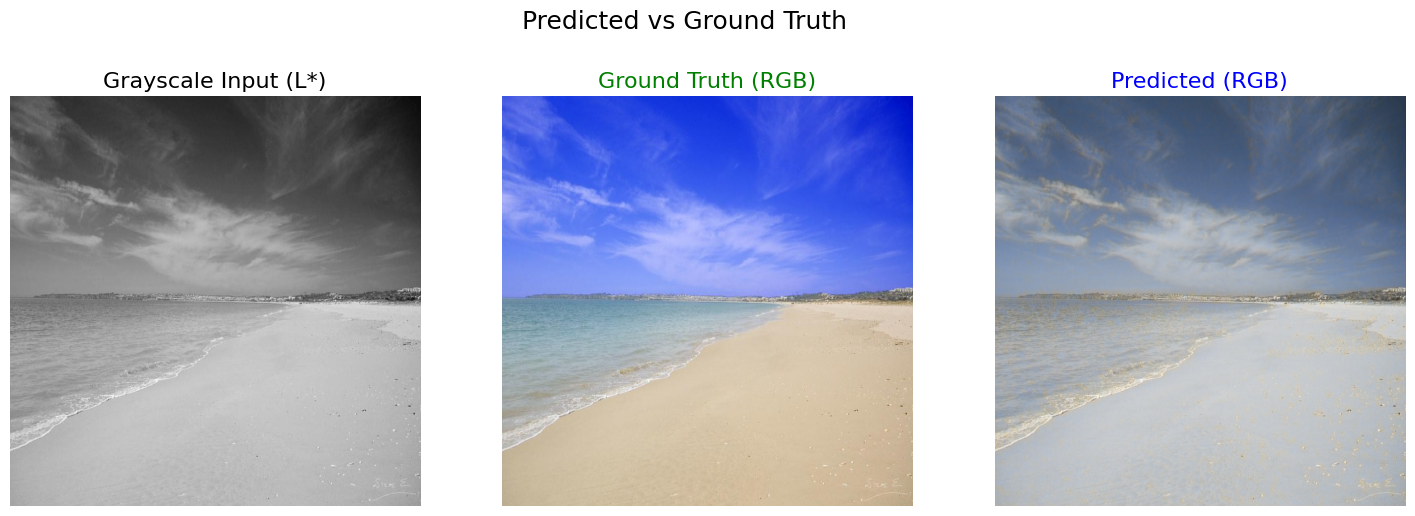

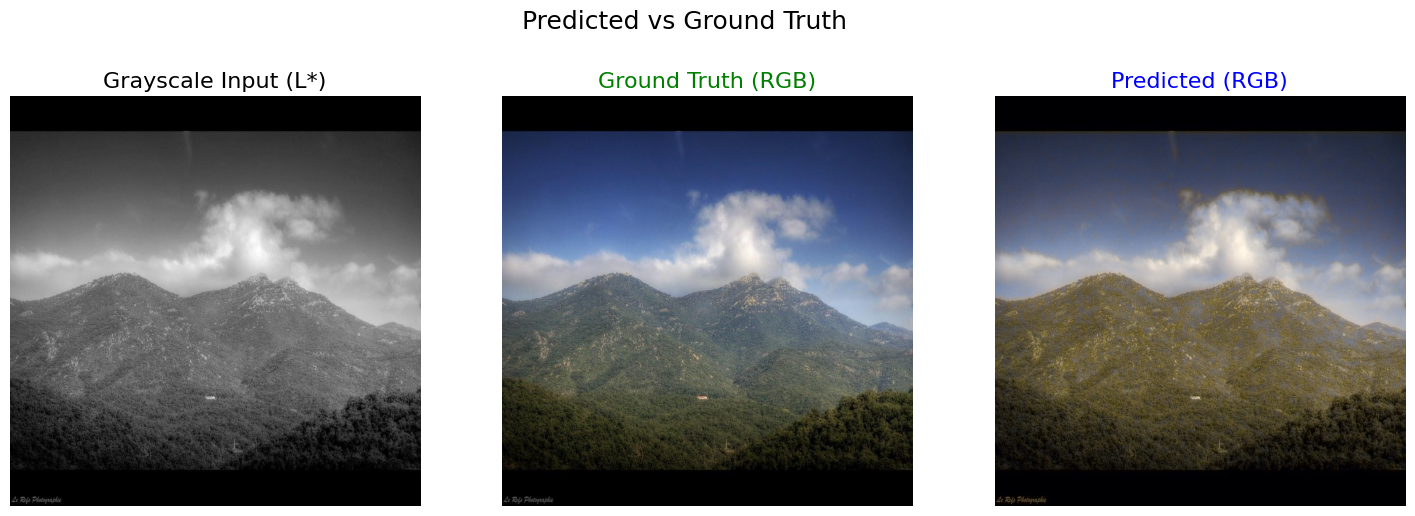

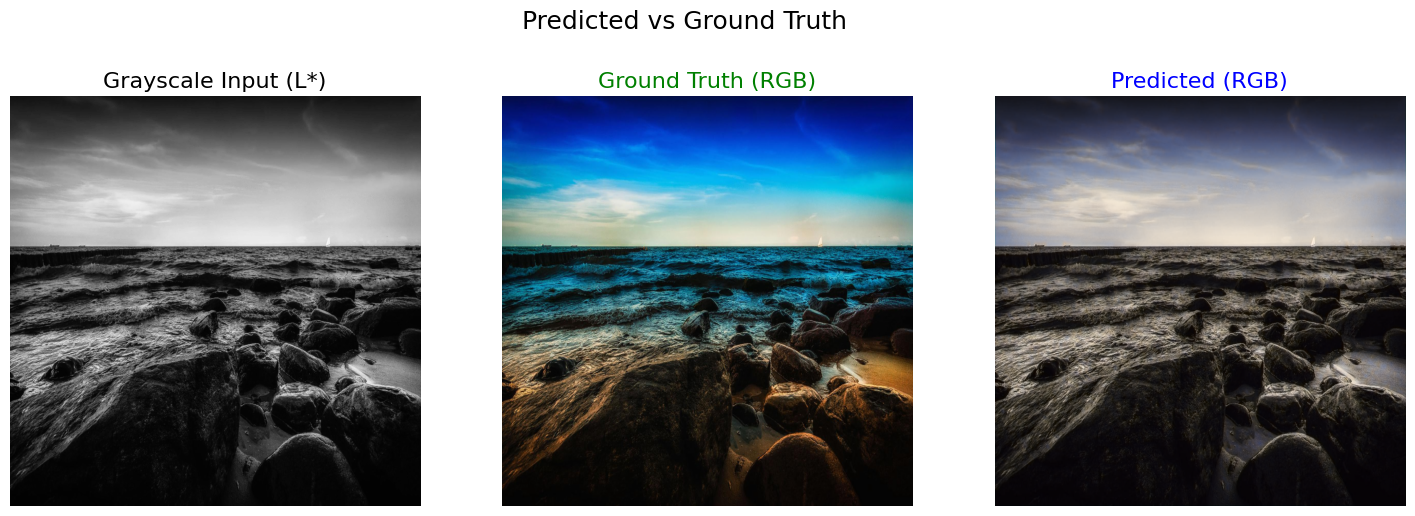

In [20]:
# Visualize Predicted Samples
def plot_predicted_samples(L_img, ab_true, ab_pred, title='Predicted Image Pair'):
    L = L_img * 100.0  # Denormalize L*
    ab_true = ab_true * 128.0  # Denormalize true a*b*
    ab_pred = ab_pred * 128.0  # Denormalize predicted a*b*

    # Combine L* with true and predicted a*b*
    lab_true = np.concatenate([L, ab_true], axis=-1)
    lab_pred = np.concatenate([L, ab_pred], axis=-1)

    # Convert to RGB
    rgb_true = lab2rgb(lab_true)
    rgb_pred = lab2rgb(lab_pred)
    rgb_true = np.clip(rgb_true, 0, 1)
    rgb_pred = np.clip(rgb_pred, 0, 1)

    # Plot
    plt.figure(figsize=(18, 6))
    plt.subplot(1, 3, 1)
    plt.title('Grayscale Input (L*)', fontsize=16, color='black')
    plt.imshow(L[..., 0], cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title('Ground Truth (RGB)', fontsize=16, color='green')
    plt.imshow(rgb_true)
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title('Predicted (RGB)', fontsize=16, color='blue')
    plt.imshow(rgb_pred)
    plt.axis('off')
    plt.suptitle(title, fontsize=18)
    plt.show()

# Visualize predictions for 3 samples from validation set
for L_img, ab_true in val_dataset.take(3):
    ab_pred = model.predict(L_img, verbose=0)
    for i in range(min(1, len(L_img))):  # Show one image per batch
        plot_predicted_samples(L_img[i].numpy(), ab_true[i].numpy(), ab_pred[i], 'Predicted vs Ground Truth')